# Analysis on the MC-Dropout model

This work explores the theoretical analysis of [Chapter 6 of Gal's PhD Thesis](https://t.co/YXw7UX7I9P?amp=1)

## Overview

* Practical considerations for getting good uncertainty
* Factors that affects predictive uncertainty characteristics
* 


## Bayesian Linear Regression example comparing BBB and MC-Dropout

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

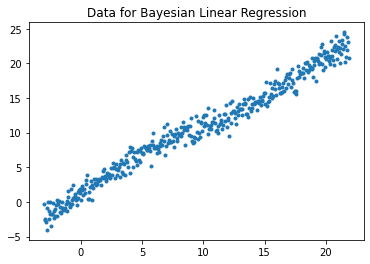

In [54]:
# Data

def generate_data(n):
  np.random.seed(1)
  x = np.linspace(0, 2*np.pi, n)
  y = 1 * np.sin(x)
  y_noise = np.concatenate((np.random.normal(0, 1, 60), 
                            y + np.random.normal(0, 1, n), 
                            np.random.normal(0, 1, 60)))
  x_extended = np.concatenate((np.linspace(-3, 0, 60), 
                               np.linspace(0, 6*np.pi, n),
                               np.linspace(6*np.pi, 6*np.pi + 3, 60)))
  y_reg = y_noise + 1 * x_extended + 1
  return x_extended, y_reg

x, y = generate_data(300)
plt.plot(x, y, '.')
plt.title("Data for Bayesian Linear Regression")
plt.show()

### Derive the posterior

Assume Prior $\mathbf{w} \sim N(0, \mathbf{I})$ \\
Likelihood $p(Y|X, \mathbf{w}) = N(\boldsymbol{\psi}(X)\mathbf{w}, \mathbf{I})$ 

\begin{align*}
\log p(\mathbf{w}| D) &= \log p(\mathbf{w}) + \log p(Y|X,\mathbf{w}) + C \\
&= -\frac{1}{2}||\mathbf{w}||^2 - \frac{1}{2}||\boldsymbol{\psi}(X)\mathbf{w} - Y||^2 + C \\
&= -\frac{1}{2} (\mathbf{w}-\mu)^TΣ^{-1}(\mathbf{w}-\mu) + C
\end{align*},

where $\Sigma^{-1} = \boldsymbol{\psi}(X)^T \boldsymbol{\psi}(X) + I$ and $\mu = (\boldsymbol{\psi}(X)^T \boldsymbol{\psi}(X) + I)^{-1}\boldsymbol{\psi}(X)^TY$

Thus the posterior of $\mathbf{w}$ is also Gaussian:
$$p(\mathbf{w}|D) = N(\mu, \Sigma)$$

In [73]:
# MC sampling using PYMC3
import pymc3 as pm

with pm.Model() as lr_model:
  pass

In [68]:
# BBB approximation using full-rank Gaussian

def neg_loglik(target, pred_distribution):
  return -pred_distribution.log_prob(target)

# KL-term corrected with *kl / num_examples_per_epoch* adjustment,
# which is independent from batch_size, as it is already averaged by batch_size 
# in forward pass once per minibatch
def weight_divergence_fn(q, p, _):
  return tfp.distributions.kl_divergence(q, p) / x.shape[0]

inputs = layers.Input(shape=(1,))
features = tfp.layers.DenseReparameterization(20, kernel_divergence_fn=weight_divergence_fn,
                                              bias_divergence_fn=weight_divergence_fn, activation="relu")(inputs)
for i in range(3):                                      
  features = tfp.layers.DenseReparameterization(20, kernel_divergence_fn=weight_divergence_fn,
                                              bias_divergence_fn=weight_divergence_fn)(features)                                                                           
params = tfp.layers.DenseReparameterization(2)(features)
pred_distribution = tfp.layers.DistributionLambda(
    lambda params: tfp.distributions.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05*params[:,1:2]))
)(params)
model_BBB = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
model_BBB.compile(tf.keras.optimizers.Adam(), loss=neg_loglik)
model_BBB.fit(x, y, epochs=200, verbose=0, batch_size=32)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


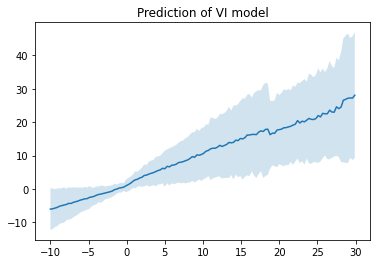

In [69]:
# test for BBB
x_test = np.arange(-10, 30, 0.3)
predictions = []
for i in range(50):
  predictions.append(model_BBB.predict(x_test))
predictions = np.array(predictions)
mu = np.squeeze(np.mean(predictions, axis=0))
std = np.squeeze(np.std(predictions, axis=0))

plt.plot(x_test, mu, label="Mean prediction")
plt.fill_between(x_test, mu - 2*std, mu + 2 * std, alpha=0.2)
plt.title("Prediction of VI model")
plt.show()

In [70]:
# MC-Dropout

inputs = layers.Input(shape=(1,))
features = layers.Dense(20, activation="relu")(inputs)
features = layers.Dropout(0.1)(features, training=True)
for i in range(3):
  features = layers.Dense(20, activation="relu")(features)
  features = layers.Dropout(0.1)(features, training=True)
params = layers.Dense(2)(features)
pred_distribution = tfp.layers.DistributionLambda(
    lambda params: tfp.distributions.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05*params[:,1:2]))
)(params)
model_Dropout = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
model_Dropout.compile(tf.keras.optimizers.Adam(), loss=neg_loglik)
model_Dropout.fit(x, y, epochs=200, verbose=0, batch_size=32)

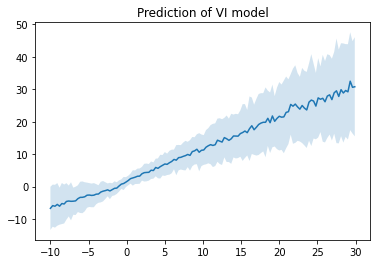

In [71]:
# test for Dropout
x_test = np.arange(-10, 30, 0.3)
predictions = []
for i in range(50):
  predictions.append(model_Dropout.predict(x_test))
predictions = np.array(predictions)
mu = np.squeeze(np.mean(predictions, axis=0))
std = np.squeeze(np.std(predictions, axis=0))

plt.plot(x_test, mu, label="Mean prediction")
plt.fill_between(x_test, mu - 2*std, mu + 2 * std, alpha=0.2)
plt.title("Prediction of VI model")
plt.show()

## What contributes to good uncertainty estimates
* A large number of parameters (model complexity) can result in better uncertainty estimates

* The dropout probability matters. Larger models requre larger dropout probabilities, since the weight of entropy is scaled by the model size $K$